In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Export Supplementary Tables_ Experimental Data.xlsx as 5 csv files and load as dataframes
calibration_df = pd.read_csv("Supplementary Tables_ Experimental Data.xlsx - Calibration.csv")
diversity_df = pd.read_csv("Supplementary Tables_ Experimental Data.xlsx - Diversity.csv")
smo1_df = pd.read_csv("Supplementary Tables_ Experimental Data.xlsx - SMO Search 1.csv")
smo2_df = pd.read_csv("Supplementary Tables_ Experimental Data.xlsx - SMO Search 2.csv")
smo3_df = pd.read_csv("Supplementary Tables_ Experimental Data.xlsx - SMO Search 3.csv")

# Compute Bliss option 2

In [3]:
def get_monotherapy_viability_d1(x, df_mult):
    if x["Drug 1 conc. (μM)"] == 0. or x["Drug 2 conc. (μM)"] == 0.:
        return None
    
    res = df_mult.loc[x["Round"], x["Drug 1 name"], x["Drug 1 conc. (μM)"], x["Drug 2 name"], 0.]   
    
    return res["Viability normalised (%)"]

def get_monotherapy_viability_d2(x, df_mult):
    if x["Drug 1 conc. (μM)"] == 0. or x["Drug 2 conc. (μM)"] == 0.:
        return None
    
    res = df_mult.loc[x["Round"], x["Drug 1 name"], 0., x["Drug 2 name"], x["Drug 2 conc. (μM)"]]
    
    return res["Viability normalised (%)"]

In [4]:
def compute_bliss_option_2(df):
    _df = df.copy(deep=True)
    df_agg = _df.groupby(["Round", "Drug 1 name", "Drug 1 conc. (μM)", 
                          "Drug 2 name", "Drug 2 conc. (μM)"])["Viability normalised (%)"].mean().reset_index()
    
    df_mult = df_agg.set_index(["Round", "Drug 1 name", "Drug 1 conc. (μM)", "Drug 2 name", "Drug 2 conc. (μM)"])
    df_mult = df_mult.sort_index()
    
    df_agg["Viability monotherapy Drug 1"] = df_agg.apply(lambda x: get_monotherapy_viability_d1(x, df_mult), axis=1)
    df_agg["Viability monotherapy Drug 2"] = df_agg.apply(lambda x: get_monotherapy_viability_d2(x, df_mult), axis=1)
    
    df_agg_f = df_agg[~df_agg["Viability monotherapy Drug 1"].isna()].copy(deep=True)
    
    df_agg_f["Bliss"] = df_agg_f.apply(lambda x: \
                                       x["Viability monotherapy Drug 1"]*x["Viability monotherapy Drug 2"]/100 - \
                                       x["Viability normalised (%)"], 
                                       axis=1)
    
    return df_agg_f
    

## Compute different aggregations

In [5]:
def get_avg_synergies_opt2(df):
    avg_df = df.groupby(["Drug 1 name", "Drug 2 name"])["Bliss"].mean().reset_index()
    avg_df["Bliss"] = avg_df["Bliss"].round(1)
    avg_df["Round"] = df["Round"].unique()[0]
    avg_df = avg_df.rename(columns={"Bliss": "avg Bliss"})
    
    return avg_df

def get_max_synergies_opt2(df):
    max_df = df.groupby(["Drug 1 name", "Drug 2 name"])["Bliss"].max().reset_index()
    max_df["Bliss"] = max_df["Bliss"].round(1)
    max_df["Round"] = df["Round"].unique()[0]
    max_df = max_df.rename(columns={"Bliss": "Max Bliss"})
    
    return max_df

def get_floored_avg_synergies_opt2(df):
    df = df.copy(deep=True)
    
    df["floored Bliss"] = df["Bliss"].apply(lambda x: max(x, 0))
    
    f_avg_df = df.groupby(["Drug 1 name", "Drug 2 name"])["floored Bliss"].mean().reset_index()
    f_avg_df["Bliss"] = f_avg_df["floored Bliss"].round(1)
    f_avg_df["Round"] = df["Round"].unique()[0]
    f_avg_df = f_avg_df.rename(columns={"floored Bliss": "floored avg Bliss"})
    
    return f_avg_df

In [6]:
all_avg_syn = pd.concat([get_avg_synergies_opt2(compute_bliss_option_2(df))
                         for df in [calibration_df, diversity_df, smo1_df, smo2_df, smo3_df]])
all_max_syn = pd.concat([get_max_synergies_opt2(compute_bliss_option_2(df))
                         for df in [calibration_df, diversity_df, smo1_df, smo2_df, smo3_df]])
all_floored_avg_syn = pd.concat([get_floored_avg_synergies_opt2(compute_bliss_option_2(df))
                         for df in [calibration_df, diversity_df, smo1_df, smo2_df, smo3_df]])

## Plots

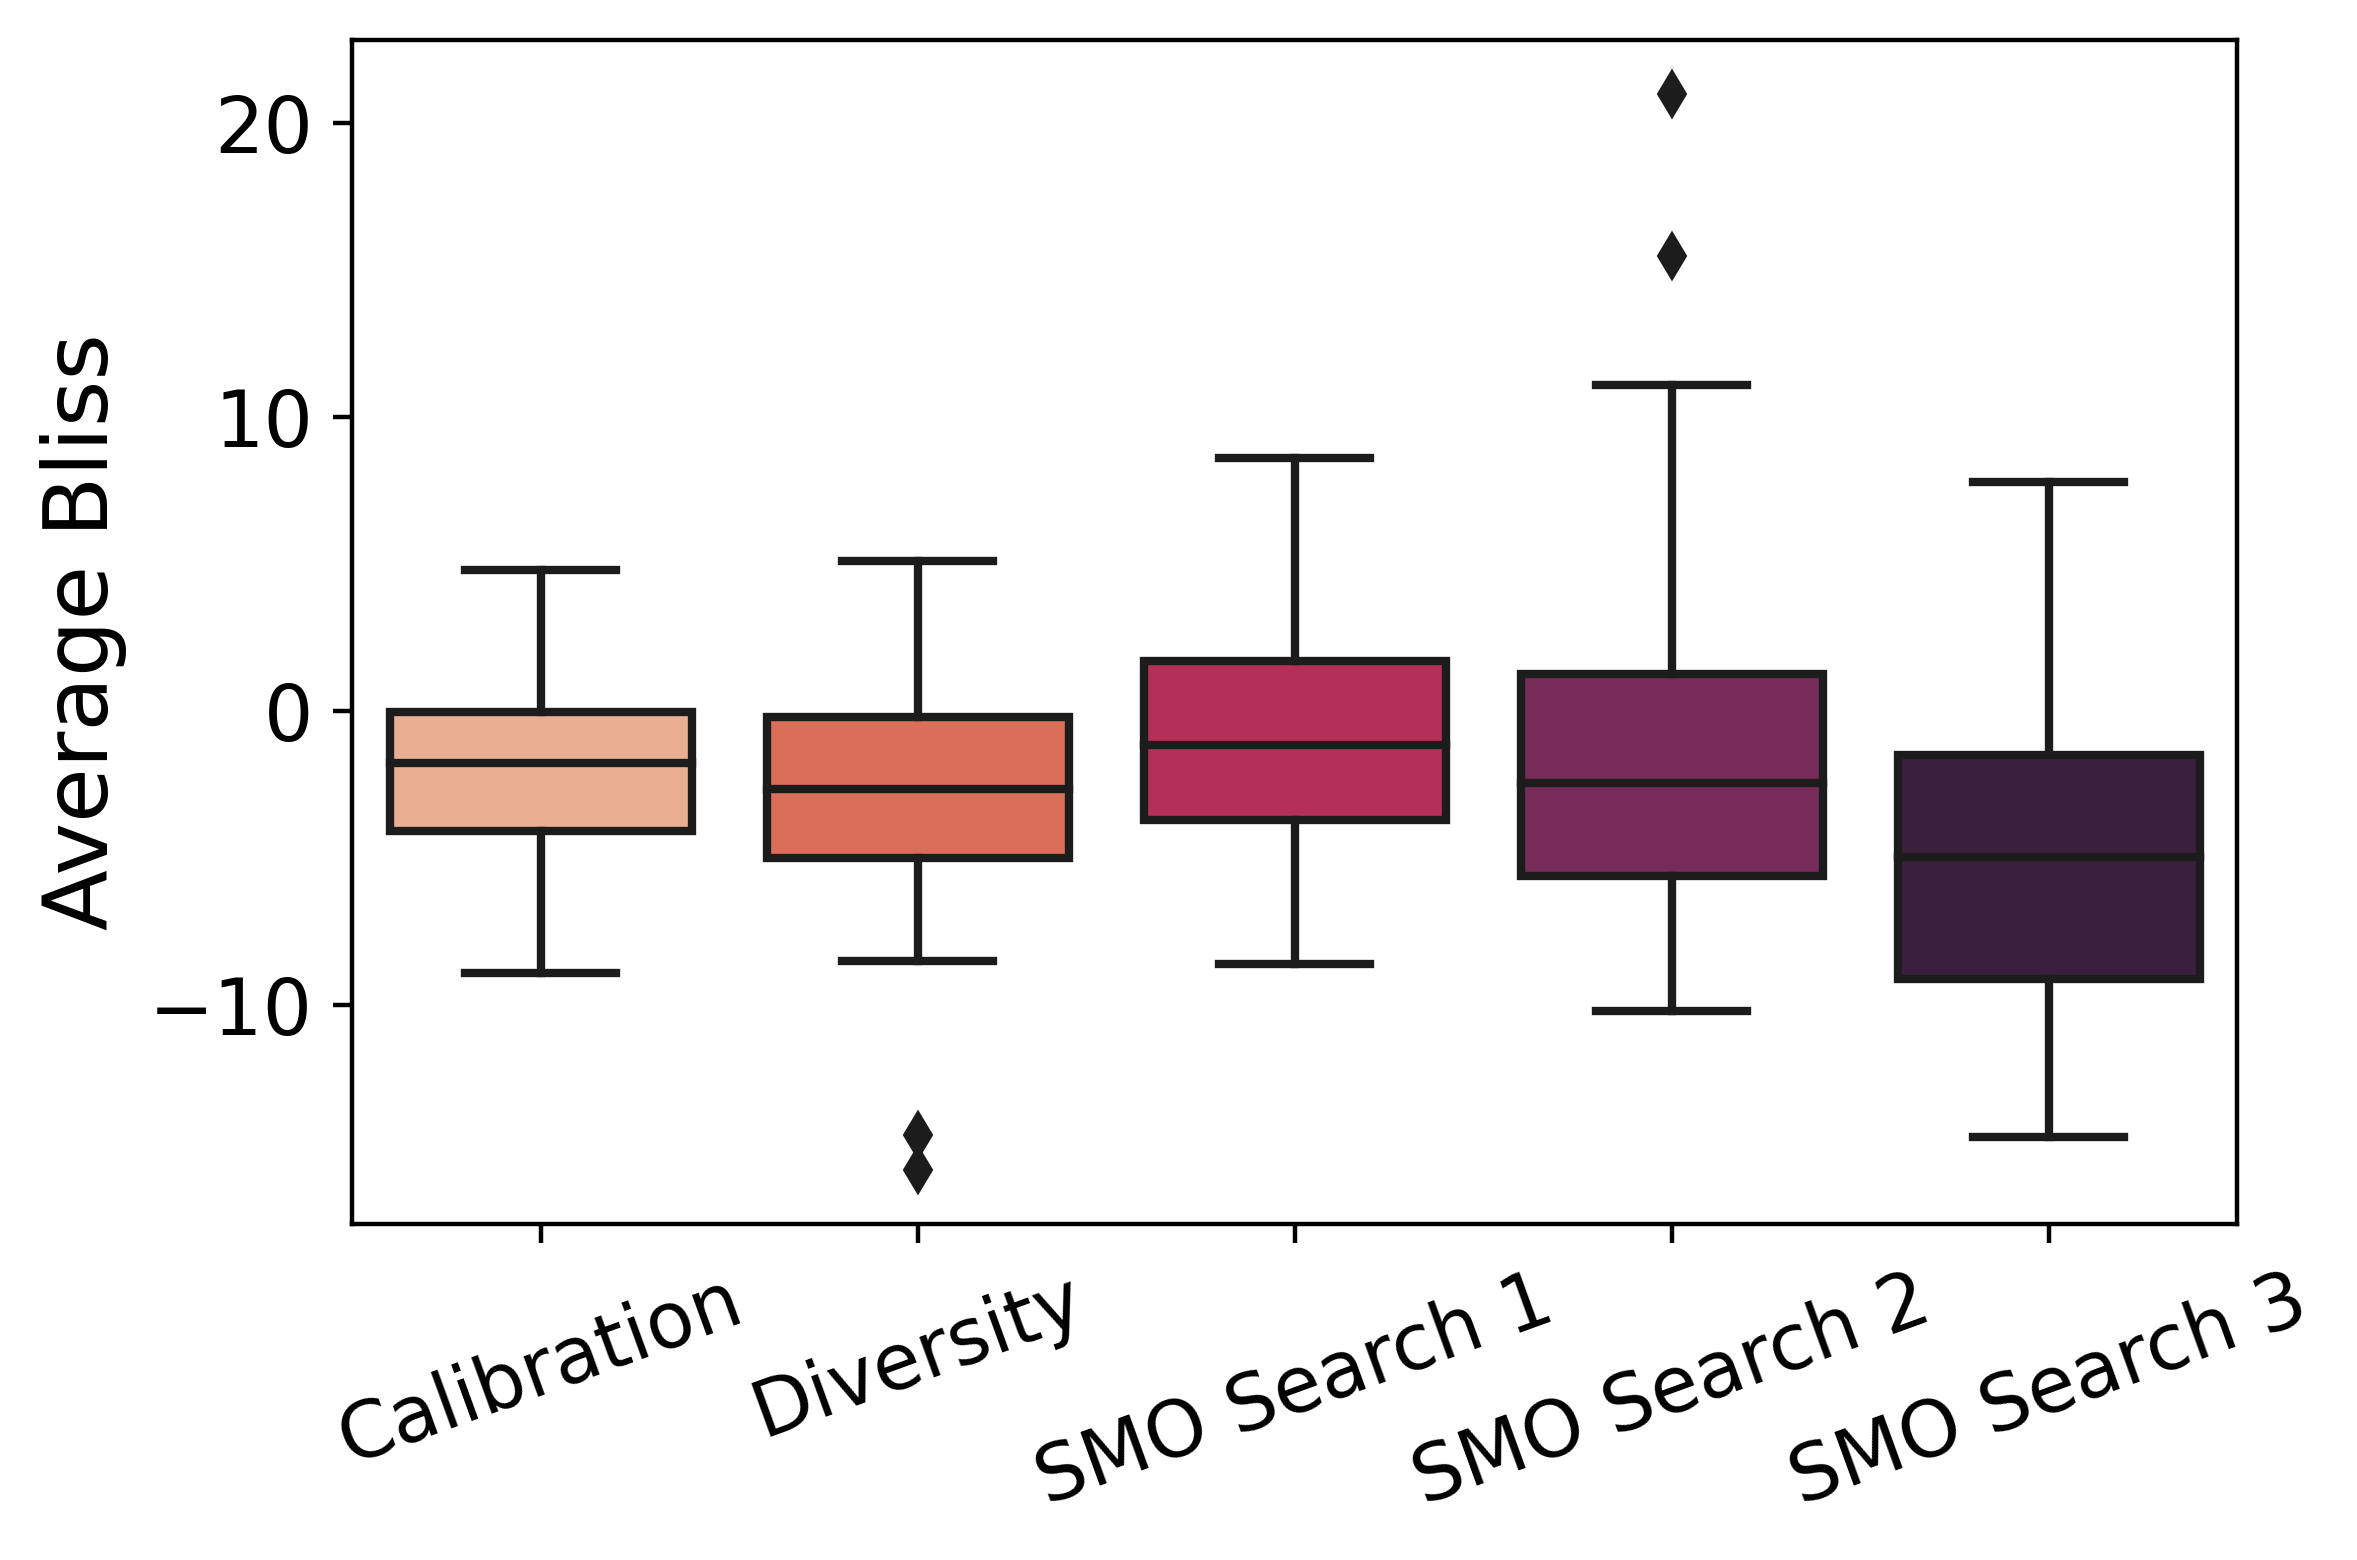

In [7]:
# Figure 4B box plot
plt.figure(figsize=(6, 4), dpi=400)
ax = sns.boxplot(data=all_avg_syn, y='avg Bliss', x='Round' , 
                 palette = sns.color_palette("rocket_r", n_colors=5) )

plt.xlabel(None)
plt.ylabel("Average Bliss", fontsize = 16)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
# ax.set_yticklabels(ax.get_yticklabels() )

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig = ax.get_figure()
fig.tight_layout()

#plt.savefig("final_figures/boxplot_max_Bliss_synergy.png", dpi=400)
plt.show()

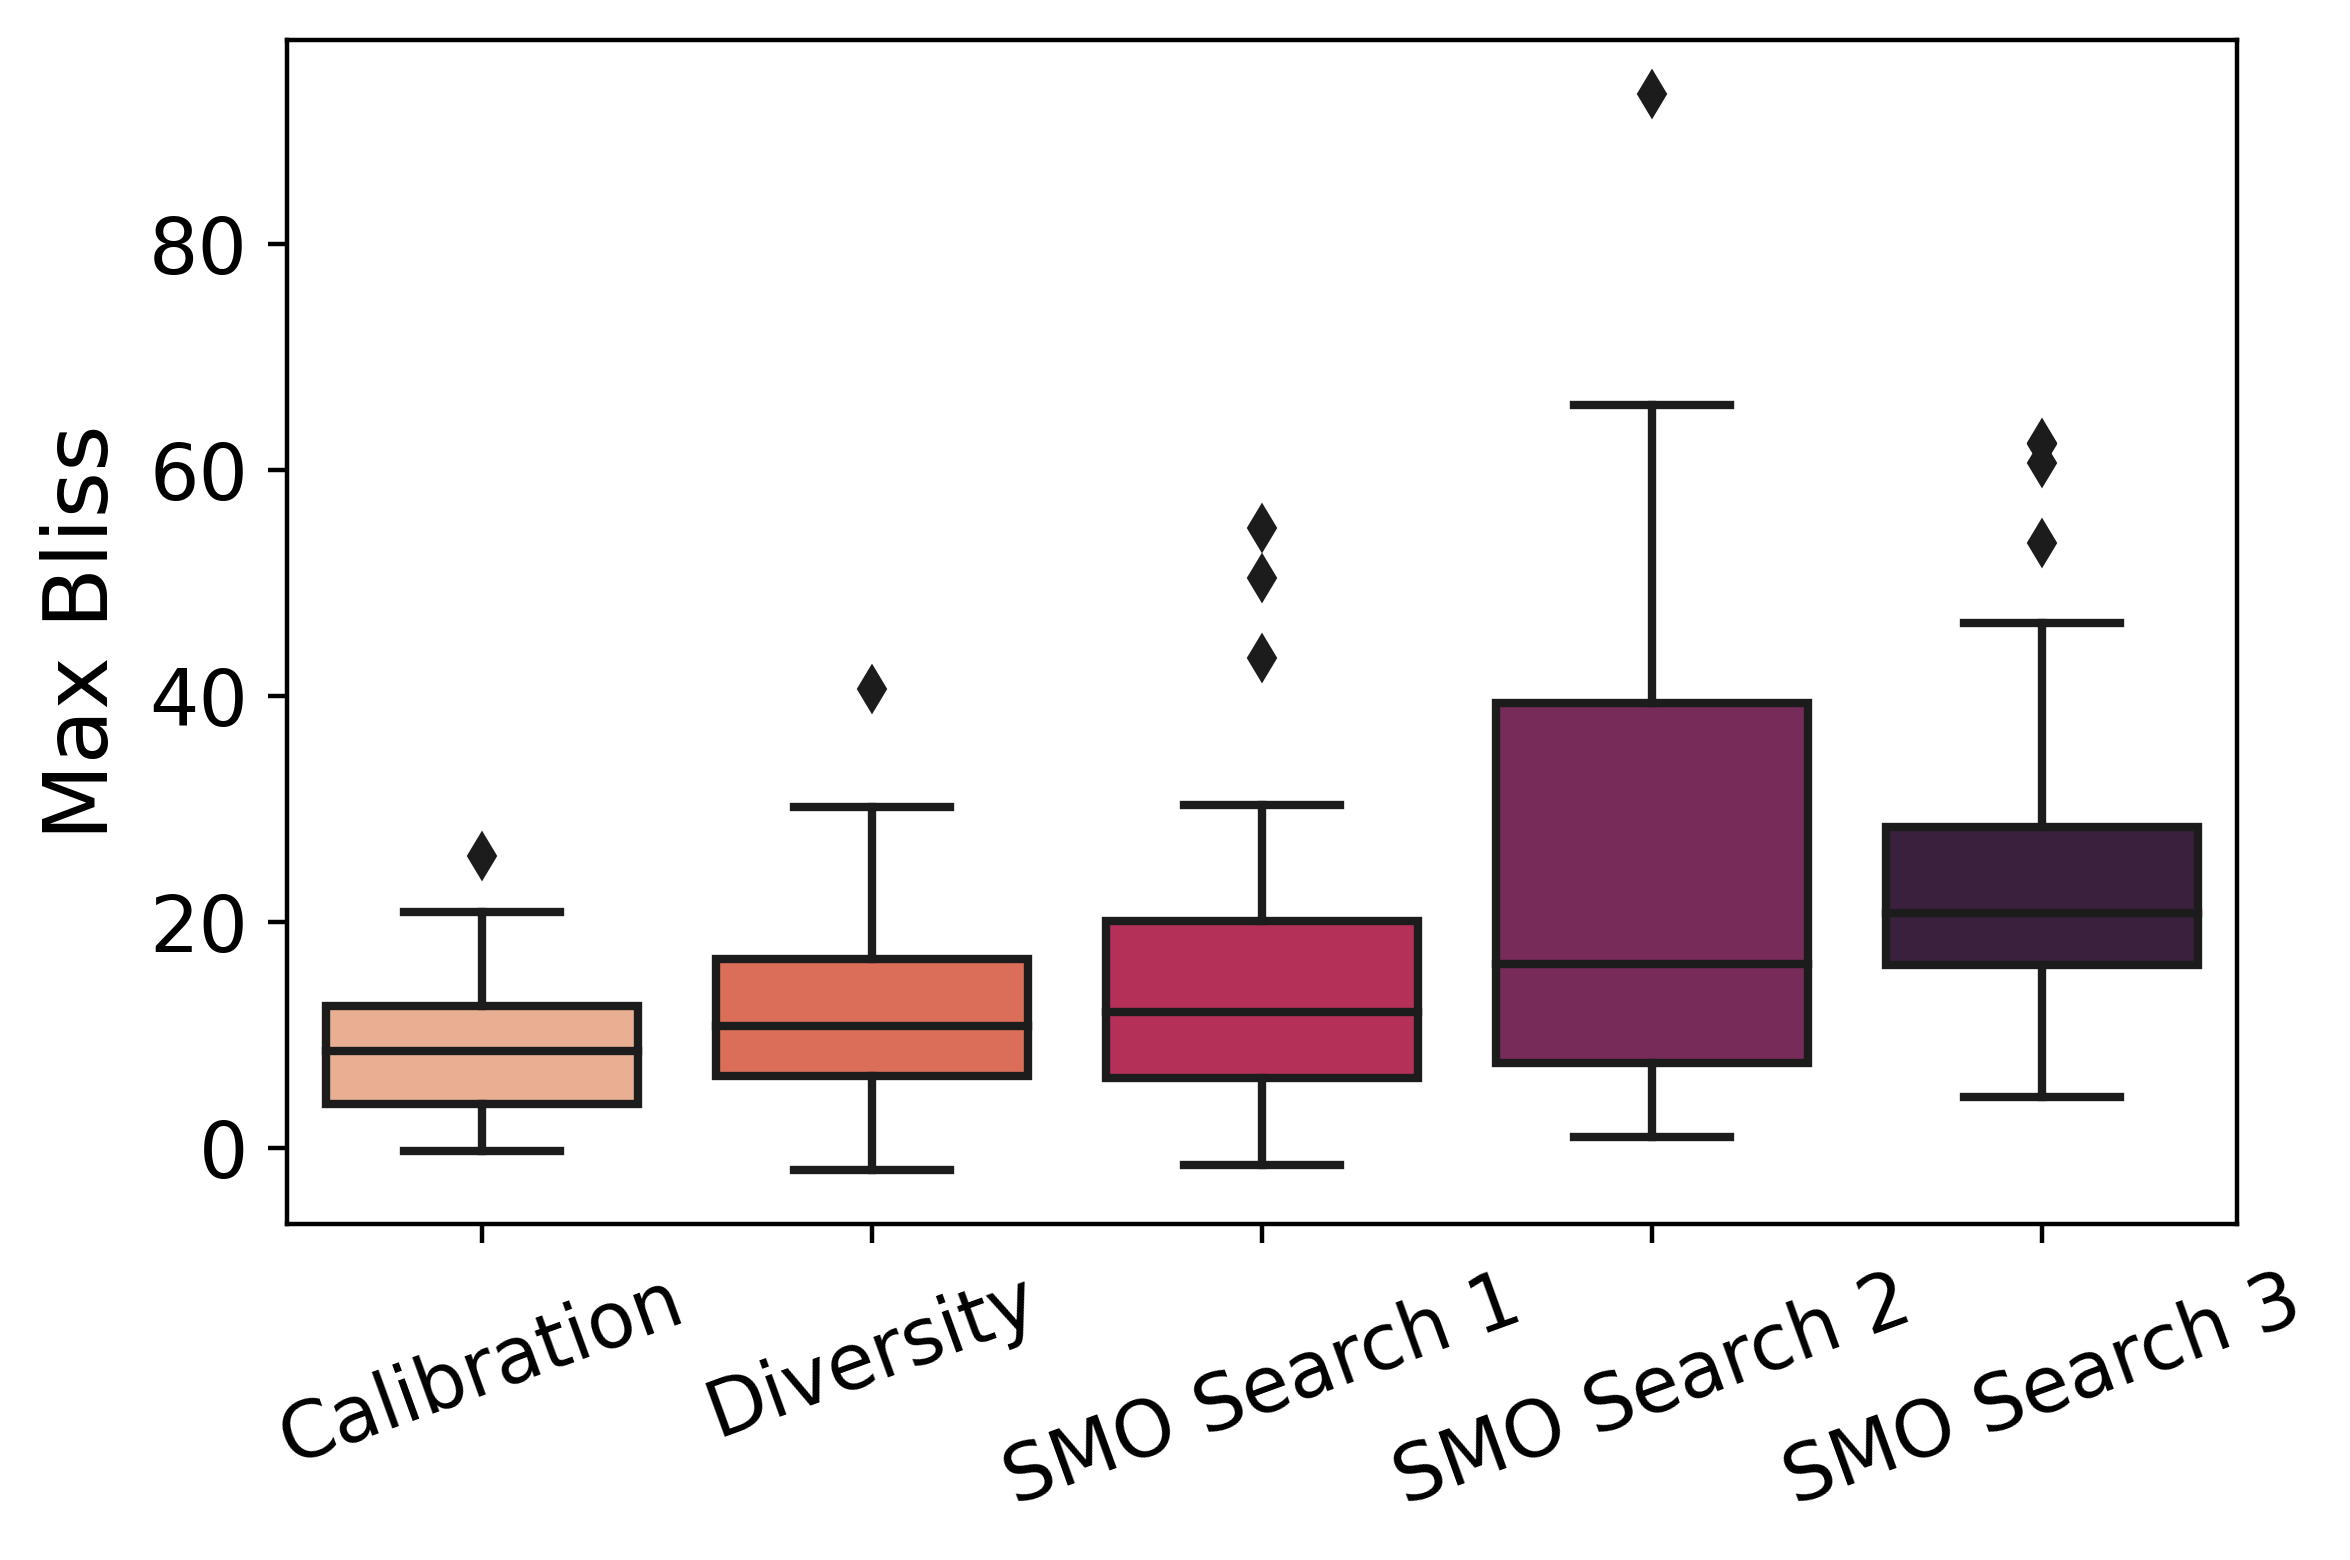

In [8]:
# Figure 4B box plot
plt.figure(figsize=(6, 4), dpi=400)
ax = sns.boxplot(data=all_max_syn, y='Max Bliss', x='Round' , 
                 palette = sns.color_palette("rocket_r", n_colors=5) )

plt.xlabel(None)
plt.ylabel("Max Bliss", fontsize = 16)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
# ax.set_yticklabels(ax.get_yticklabels() )

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig = ax.get_figure()
fig.tight_layout()

#plt.savefig("final_figures/boxplot_max_Bliss_synergy.png", dpi=400)
plt.show()

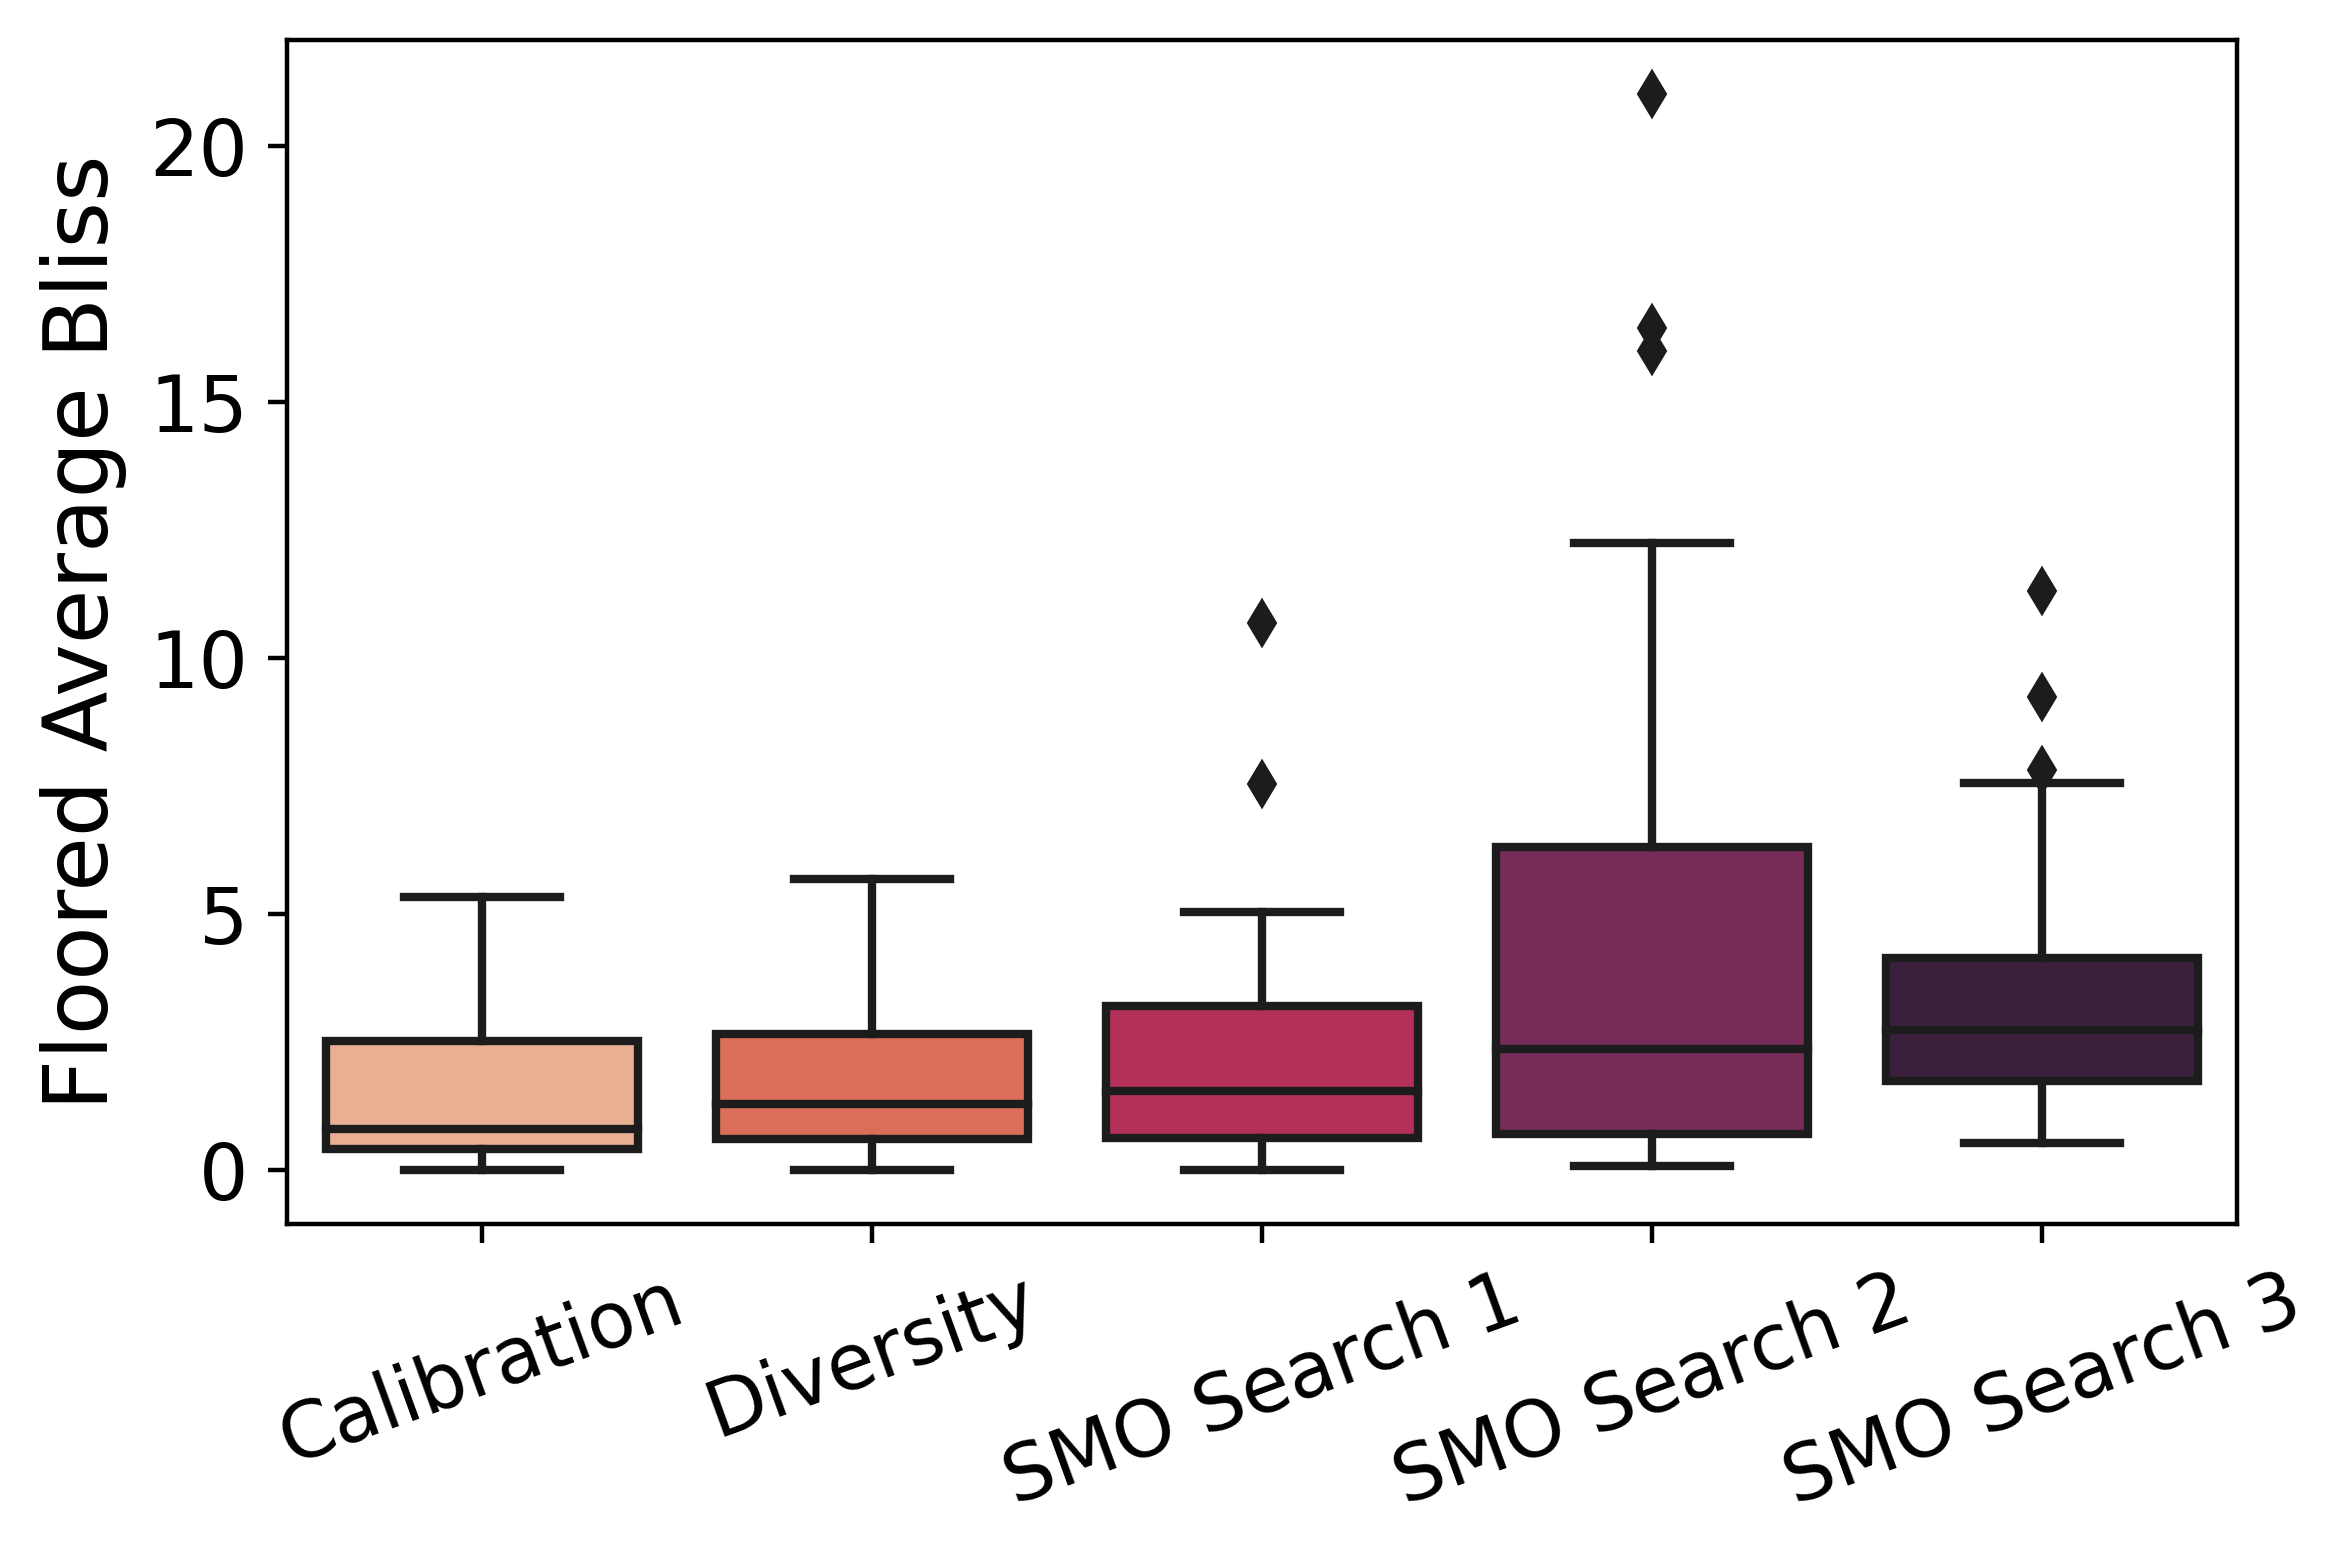

In [9]:
# Figure 4B box plot
plt.figure(figsize=(6, 4), dpi=400)
ax = sns.boxplot(data=all_floored_avg_syn, y='floored avg Bliss', x='Round' , 
                 palette = sns.color_palette("rocket_r", n_colors=5) )

plt.xlabel(None)
plt.ylabel("Floored Average Bliss", fontsize = 16)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
# ax.set_yticklabels(ax.get_yticklabels() )

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig = ax.get_figure()
fig.tight_layout()

#plt.savefig("final_figures/boxplot_max_Bliss_synergy.png", dpi=400)
plt.show()

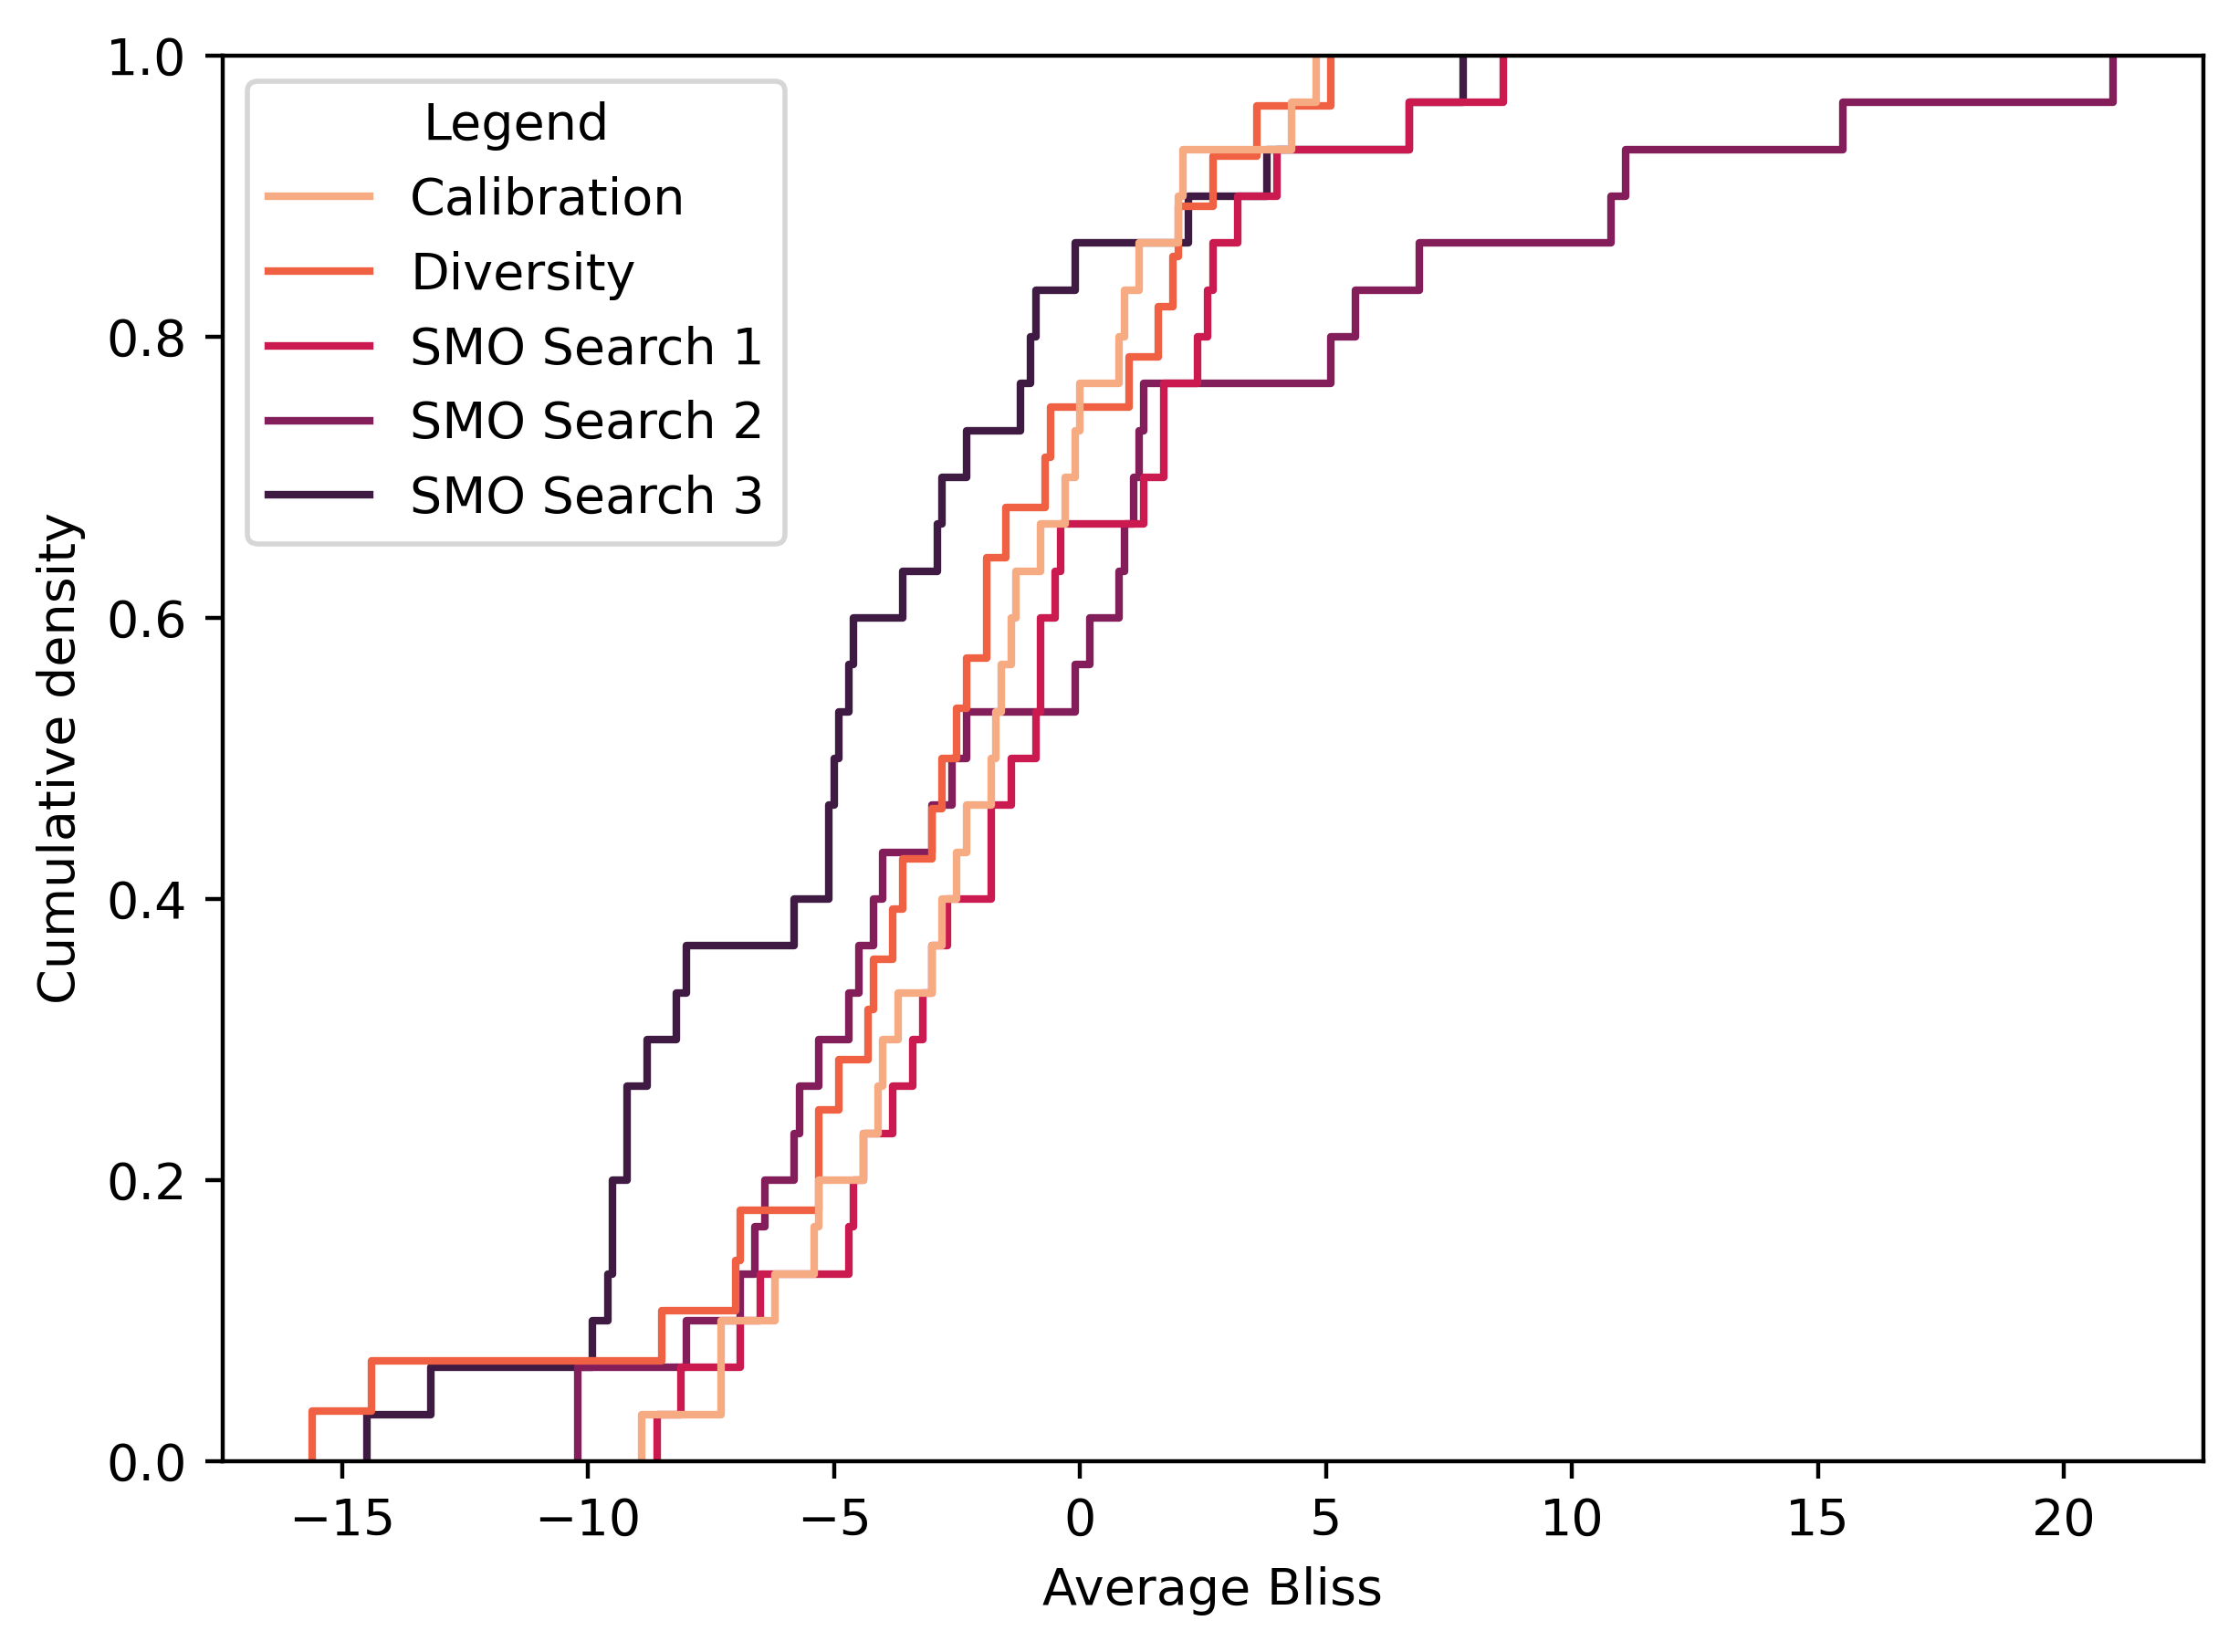

In [10]:
# Figure 4B denstiy plot
plt.figure(figsize=(7, 5), dpi=400)
ax = sns.ecdfplot(data=all_avg_syn.rename(columns={'Round': 'Legend'}), x='avg Bliss', hue='Legend', 
                  palette = sns.color_palette("rocket_r", n_colors=5) )
ax.set(xlabel='Average Bliss', ylabel='Cumulative density')

#plt.ylabel("Cumulative density")

#plt.savefig("final_figures/ECDF_max_Bliss_synergy.png", dpi=400)
plt.show()

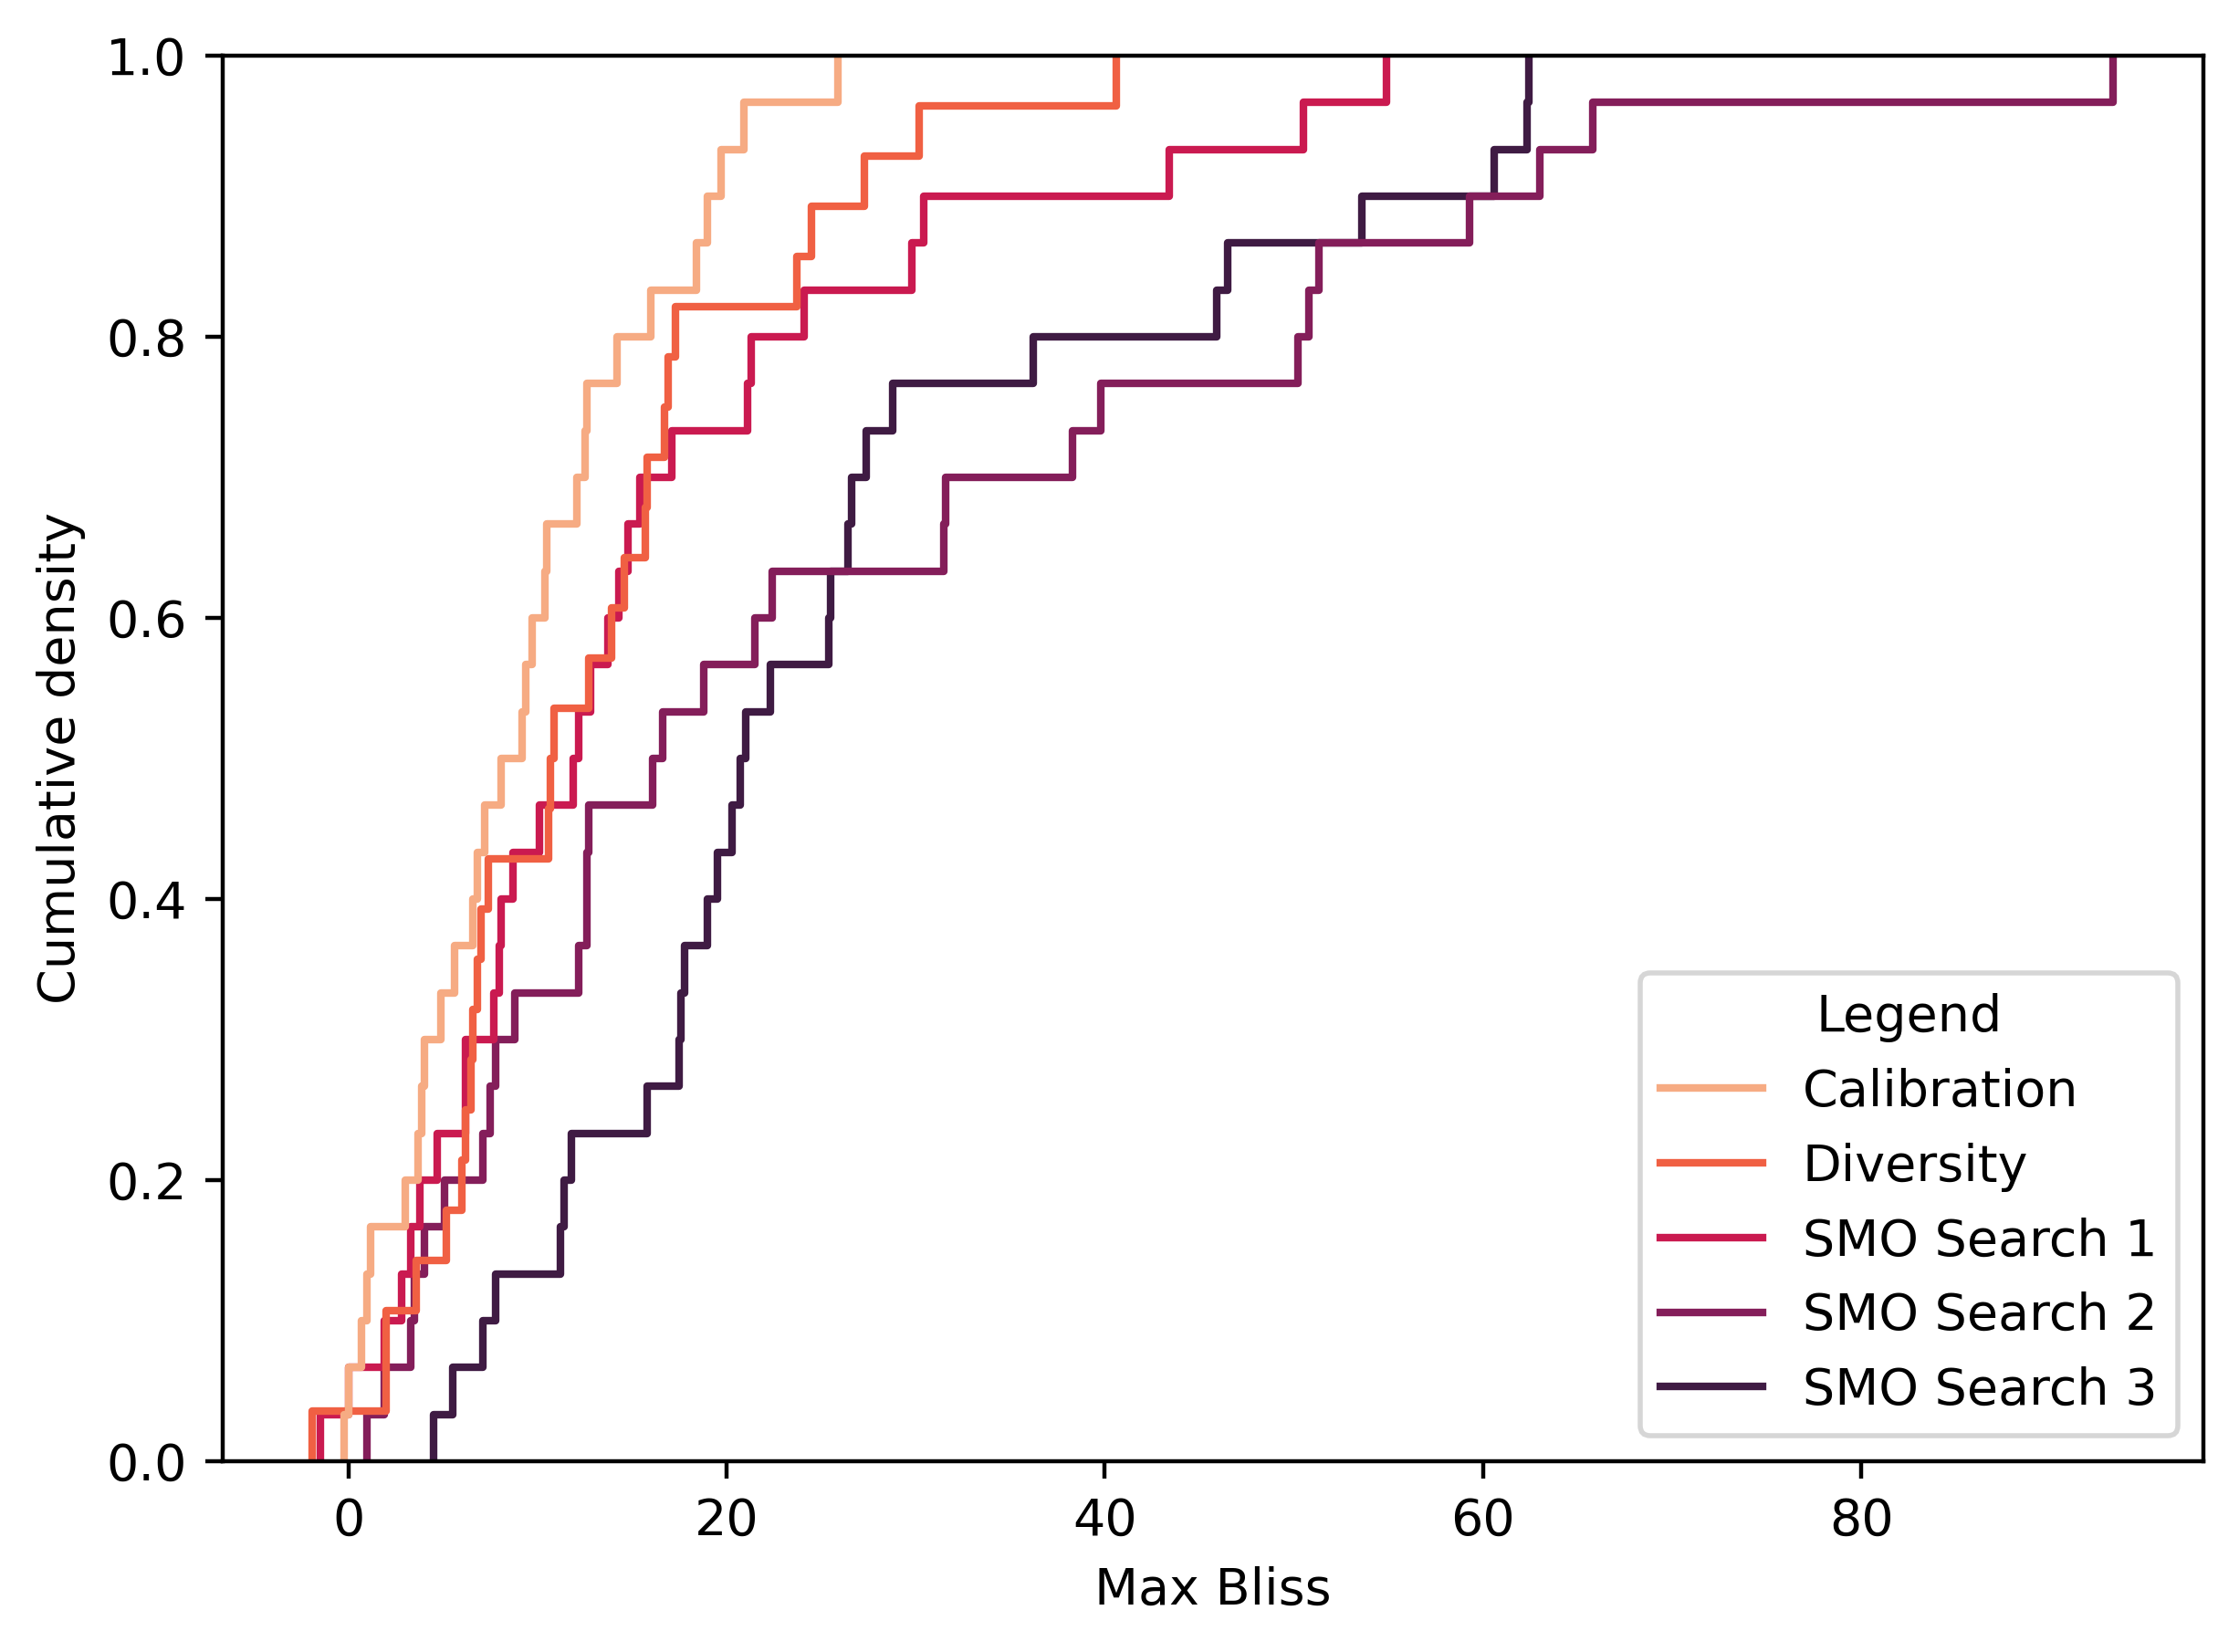

In [11]:
# Figure 4B denstiy plot
plt.figure(figsize=(7, 5), dpi=400)
ax = sns.ecdfplot(data=all_max_syn.rename(columns={'Round': 'Legend'}), x='Max Bliss', hue='Legend', 
                  palette = sns.color_palette("rocket_r", n_colors=5) )
ax.set(xlabel='Max Bliss', ylabel='Cumulative density')

#plt.ylabel("Cumulative density")

#plt.savefig("final_figures/ECDF_max_Bliss_synergy.png", dpi=400)
plt.show()

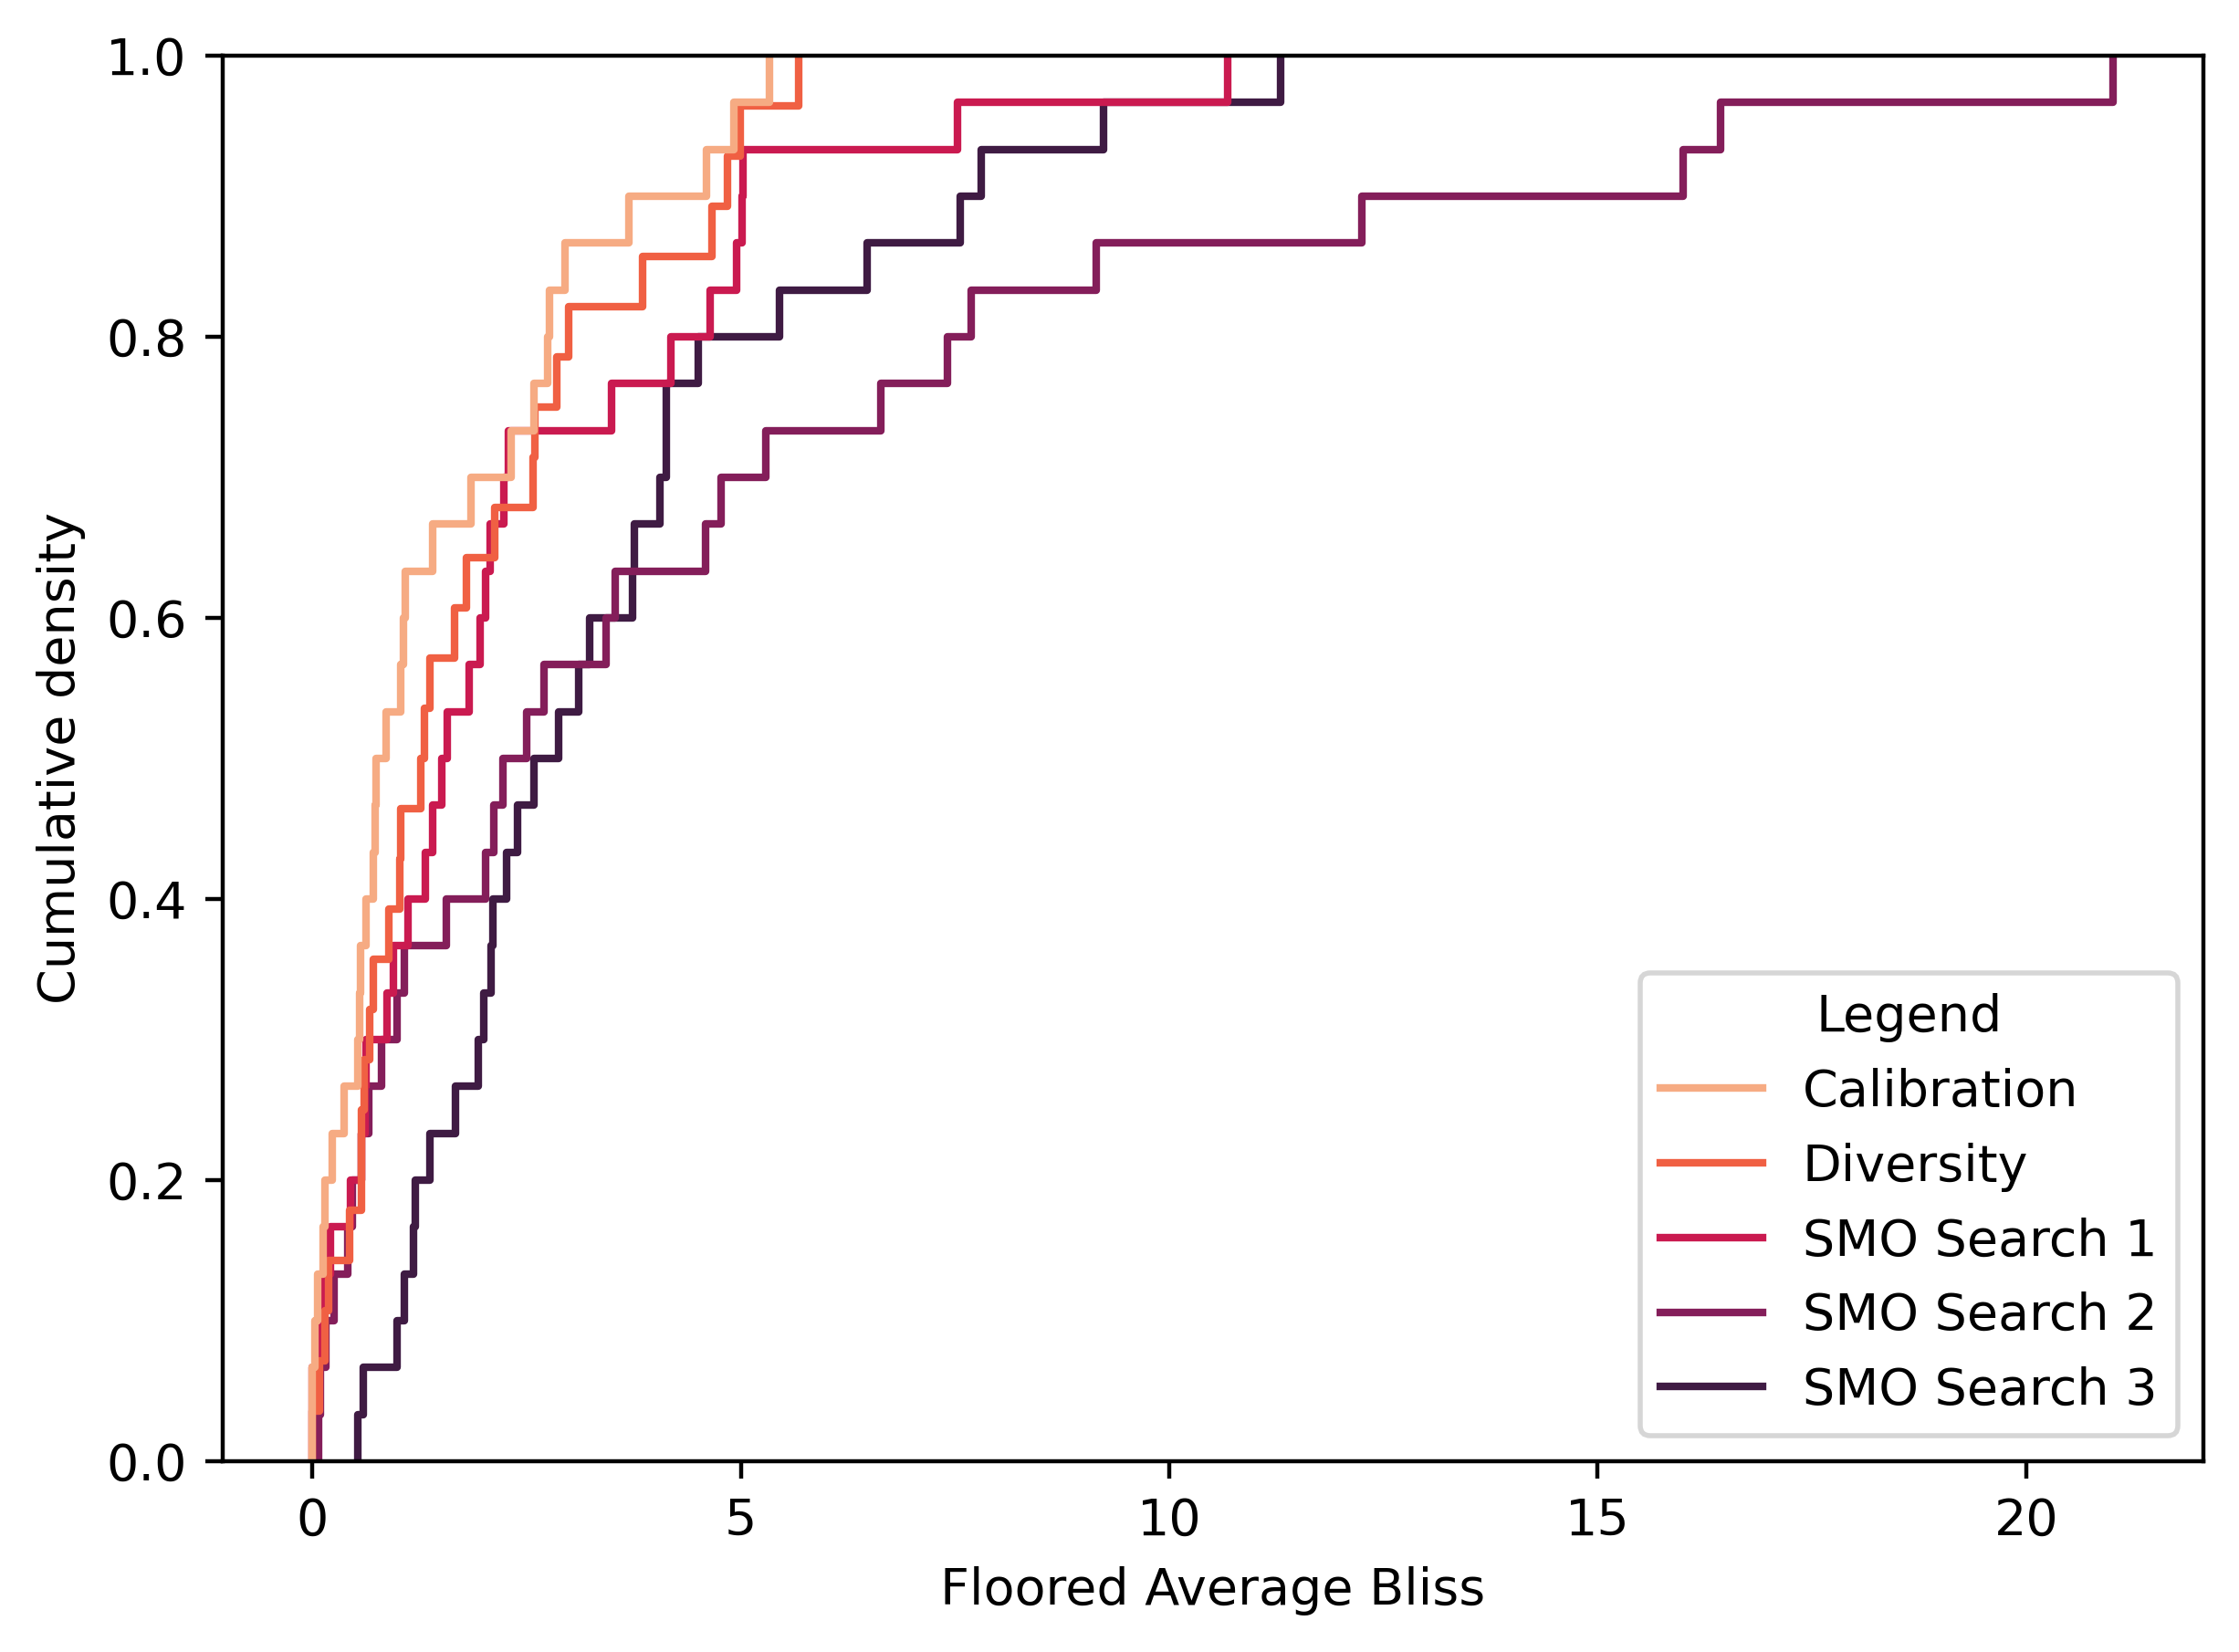

In [12]:
# Figure 4B denstiy plot
plt.figure(figsize=(7, 5), dpi=400)
ax = sns.ecdfplot(data=all_floored_avg_syn.rename(columns={'Round': 'Legend'}), x='floored avg Bliss', hue='Legend', 
                  palette = sns.color_palette("rocket_r", n_colors=5) )
ax.set(xlabel='Floored Average Bliss', ylabel='Cumulative density')

#plt.ylabel("Cumulative density")

#plt.savefig("final_figures/ECDF_max_Bliss_synergy.png", dpi=400)
plt.show()